# Cooling Loop Pressure Drops

Calculation of the overall pressure drop, including the expected losses in the cooling jacket inlet and outlet.


### References:
- [1] - https://neutrium.net/fluid-flow/pressure-loss-from-fittings-excess-head-k-method/
- [2] - https://neutrium.net/fluid-flow/pressure-loss-from-fittings-expansion-and-reduction-in-pipe-size/
- [3] - https://en.wikipedia.org/wiki/Hydraulic_diameter#List_of_hydraulic_diameters

In [1]:
import white_dwarf
import numpy as np
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 130

In [2]:
data = white_dwarf.get_data()

Loaded 1921 thermo species
Loaded 1031 propellants


C:\Users\Daniel\OneDrive - University of Cambridge\Cambridge\CUSF\Github Repositories\White-Dwarf-Cooling\white_dwarf.py:124: UserWarning: The area ratio provided (2.147421889767617) is outside of the range of available data. Maximum available is 54.623, minimum is 3.678. Will use a 15 degree cone instead.
  xs, ys = bam.rao.get_rao_contour(r_c = Rc,
C:\Users\Daniel\OneDrive - University of Cambridge\Cambridge\CUSF\Github Repositories\White-Dwarf-Cooling\white_dwarf.py:245: UserWarning: More than one wall is present. Thermal stresses calculations will ignore any incompatibility in different thermal expansions.
  cooling_data = engine.steady_heating_analysis()
C:\Users\Daniel\anaconda3\lib\site-packages\bamboo\engine.py:1249: RuntimeWarning: divide by zero encountered in double_scalars
  results["sigma_t_pressure"][i][j] = (p_l - p_g) * D / (2 * t_w)


### Plumbing Set Up

Assume the following plumbing loop:

- 1 m pipe from pump to engine inlet, 20 mm diameter.
- 20 mm orifice for engine inlet.
- Inlet distribution ring is a pipe curved along a half-circular arc (radius 75.55 mm), with flow area  6.27e-4 m$^2$ (rectangle of sides 20.90 mm by 30 mm).
- 90 degree turn into cooling channels, K-type pressure drop ($\Delta p = \frac{1}{2} \rho V^2 K$) with K = 1.3 [1]. Take the area as 0.0111 m$^2$.
- Area contraction into cooling channels, modelled as K-type drop [2]. Take the initial area as 0.0111 m$^2$ (annulus with $r_{in}$ = 62.1 mm and $r_{out}$ = 86mm).
- Pressure drop across cooling jacket.
- Outlet distribution ring, curved along a half-circular rac (radius 62.575mm), with a rectangular flow cross section (dimensions unconfirmed).
- 1 m pipe from engine back to water bucket, 20 mm diameter.
- Outlet into bucket, modelled as a 20 mm diameter orifice.

Note that you should usually use the inlet velocity with K-value pressure drops.

In [3]:
# Function to calculate pipe pressure drops
REDH_LAMINAR = 2300
REDH_TURBULENT = 3500

def f_darcy(ReDh, Dh):
    
    if ReDh < REDH_LAMINAR:
         # Laminar
        return 64.0 / ReDh         
    
    else:
        f_darcy_turbulent = (0.79 * np.log(ReDh) - 1.64)**(-2)   # Putukhov equation for smooth pipes
    
    
        if ReDh < REDH_TURBULENT:
            # Transitional  
            f_darcy_laminar = 64.0 / ReDh     

            # "Blend" between the laminar and turbulent region
            return np.interp(ReDh, [REDH_LAMINAR, REDH_TURBULENT], [f_darcy_laminar, f_darcy_turbulent])

        else:
            # Turbulent
            return f_darcy_turbulent

def dp_dx(f_darcy, rho, V, Dh):
    return f_darcy * (rho / 2) * (V**2) / Dh

First set up the problem nicely.

In [4]:
CD = 0.7
mdot = white_dwarf.inputs["mdot_coolant"]
rho = (data["rho_coolant"][0] + data["rho_coolant"][-1] ) / 2   # Average density
mu = PropsSI("VISCOSITY", "T", data["T_coolant"][0], "P", data["p_coolant"][0], "WATER")

# Delivery pipe
L1 = 1
D1 = 20e-3
A1 = np.pi * D1**2 / 4
V1 = mdot / (A1 * rho)
Re1 = rho * V1 * D1 / mu

# Inlet orifice
CD2 = CD
D2 = 20e-3
A2 = np.pi * D2**2 / 4

# Inlet distribution ring
L3 = 0.5 * (2 * np.pi * 75.55e-3) # Only travel half way around the circle
A3 = 6.27e-4
DH3 = 2 * 20.9e-3 * 30e-3 / (20.9e-3 + 30e-3)   # Reference [3]
V3 = mdot / (A3 * rho)
Re3 = rho * V3 * DH3 / mu

# Turn into cooling channels
K4 = 1.3
A4 = 0.0111
V4 = mdot / (A4 * rho)

# Area change into cooling channels
A5_IN = 0.0111
DH5_IN = (86e-3 * 2) - (62.1e-3 * 2)
V5_IN =  mdot / (A5_IN * rho)
A5_OUT = mdot / (data["V_coolant"][0] * data["rho_coolant"][0])
Re5_IN = rho * V5_IN * DH5_IN / mu

if Re5_IN < 2500:
    K5 = (1.2 + 160 / Re5_IN) * ((A5_IN / A5_OUT)**2 - 1)   # Reference [2] 
else:
    f_darcy_5 = f_darcy(ReDh = Re5_IN, Dh = DH5_IN)
    K5 = (0.6 + 0.48 * f_darcy_5) * (A5_IN / A5_OUT) * (A5_IN / A5_OUT - 1)
    
# Cooling jacket
DP6 = abs(data["p_coolant"][0] - data["p_coolant"][-1])

# Outlet distribution ring
W_DIST_OUT = 27e-3    # Rectangle width
H_DIST_OUT = 10.15e-3    # Rectangle height 

L_DIST_OUT = 0.5 * (2 * np.pi * 62.575e-3) # Only travel half way around the circle
A_DIST_OUT = W_DIST_OUT * H_DIST_OUT
DH_DIST_OUT = 2 * H_DIST_OUT * W_DIST_OUT / (H_DIST_OUT + W_DIST_OUT)   # Reference [3]
V_DIST_OUT = mdot / (A_DIST_OUT * rho)
Re_DIST_OUT = rho * V_DIST_OUT * DH_DIST_OUT / mu

# Return pipe
L8 = 1
D8 = D1
A8 = np.pi *D8**2 / 4
V8 = mdot / (A8 * rho)
Re8 = rho * V8 * D8 / mu

# Into bucket
CD9 = CD
D9 = 20e-3
A9 = np.pi * D9**2 / 4

Now calculate the pressure drops themselves.

In [5]:
# Delivery pipe
f_darcy_1 = f_darcy(ReDh = Re1, Dh = D1)
dp_dx_1 = dp_dx(f_darcy = f_darcy_1, rho = rho, V = V1, Dh = D1)

DP1 = dp_dx_1 * L1

# Inlet orifice
DP2 = (mdot / CD2 / A2)**2 / (2 * rho)

# Inlet distribution ring
f_darcy_3 = f_darcy(ReDh = Re3, Dh = DH3)
dp_dx_3 = dp_dx(f_darcy = f_darcy_3, rho = rho, V = V3, Dh = DH3)

DP3 = dp_dx_3 * L3

# Turn into cooling channels
DP4 = K4 * 0.5 * rho * V4**2

# Area change into cooling channels
DP5 = K5 * 0.5 * rho * V5_IN**2

# Cooling jacket is already done

# Outlet distribution ring
f_darcy_dist_out = f_darcy(ReDh = Re_DIST_OUT, Dh = DH_DIST_OUT)
dp_dx_dist_out = dp_dx(f_darcy = f_darcy_dist_out, rho = rho, V = V_DIST_OUT, Dh = DH_DIST_OUT)

DP_DIST_OUT = dp_dx_dist_out * L_DIST_OUT

# Return pipe
f_darcy_8 = f_darcy(ReDh = Re8, Dh = D8)
dp_dx_8 = dp_dx(f_darcy = f_darcy_8, rho = rho, V = V8, Dh = D8)

DP8 = dp_dx_8 * L8

# Into bucket orifice
DP9 = (mdot / CD9 / A9)**2 / (2 * rho)


Breakdown:
0.50 m (Delivery pipe)
1.06 m (Inlet orifice)
0.03 m (Inlet distribution)
0.00 m (90 deg turn into channels)
0.10 m (Area change into channels)
0.72 m (Channels friction)
0.18 m (Oulet distribution)
0.50 m (Return pipe)
1.06 m (Into bucket)

Total pressure drop = 40810.93623708997 Pa
                    = 4.160136211731903 m of water head

Excluding orifices  = 2.036607666472354 m of water head


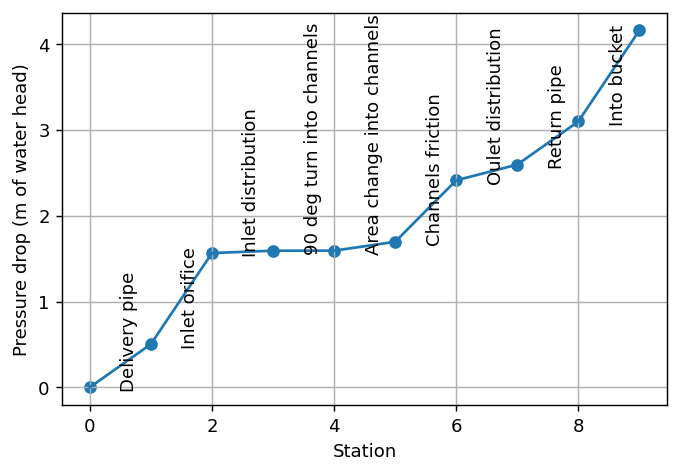

In [6]:
# Plot everything
x = [0,1,2,3,4,5,6,7,8, 9]
DP = [0, DP1, DP2, DP3, DP4, DP5, DP6, DP_DIST_OUT, DP8, DP9]
labels = ["Delivery pipe",
          "Inlet orifice", 
          "Inlet distribution", 
          "90 deg turn into channels", 
          "Area change into channels", 
          "Channels friction", 
          "Oulet distribution",
          "Return pipe",
          "Into bucket"]

DP_TOTAL = sum(DP)
DP_EACH_STATION = np.cumsum(DP)
DP_EACH_STATION_HEAD = DP_EACH_STATION/1000/9.81

plt.plot(x, DP_EACH_STATION_HEAD)
plt.scatter(x, DP_EACH_STATION_HEAD)

print("Breakdown:")
for i in range(len(labels)):
    plt.text(x[i] + 0.5, DP_EACH_STATION_HEAD[i], labels[i], rotation = "vertical")
    
    print(f"{DP[i+1]/1000/9.81:.2f} m ({labels[i]})")


print(f"\nTotal pressure drop = {DP_TOTAL} Pa")
print(f"                    = {DP_EACH_STATION_HEAD[-1]} m of water head")

print(f"\nExcluding orifices  = {(DP_TOTAL - DP2 - DP9)/1000/9.81} m of water head")



plt.xlabel("Station")
plt.ylabel("Pressure drop (m of water head)")
plt.grid()

plt.savefig("img/cooling_pressure_drop.svg")

plt.show()